In [21]:
import numpy as np
import pandas as pd
from data_loader import load_names_from_web, holdout_split, year_split, births_per_year
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import kendalltau
import shap
import matplotlib

In [22]:
dfraw = load_names_from_web(category='national', hide_pre_1937=True, use_existing_files=True)
# traintestval, holdout = year_split(dfraw, holdout_size=30)
trainval, test = year_split(dfraw, holdout_size=30)
births_by_year = births_per_year()

In [23]:
# sorted(trainval['year'].unique())

In [24]:
def get_all_known_names(data):

    names = data.groupby(['state', 'name', 'M/F']).size().reset_index()
    names = names[['state', 'name', 'M/F']]
    return names

In [25]:
def select_top_names(data, first_year_to_predict, cutoff=10):
    '''
    Select names that have had at least one year at or above the cutoff count?
    Could also try to redo this to do the cutoff for the most recent known year's data
    '''

    data_noleak = data[data['year'] < first_year_to_predict]
    names = data_noleak[data_noleak['count'] >= cutoff][['state', 'name', 'M/F']].drop_duplicates()
    # display(names)
    data = names.merge(data, how='left', on=['state', 'name', 'M/F'])
    # display(data)

    return data

In [26]:
def classify(df, names_csv):

    '''
    PEAKS
    '''

    # peaks = df.loc[df.groupby(['state', 'name', 'M/F'])['count'].idxmax()][['state', 'name', 'M/F', 'year']]
    # peaks = peaks.rename(columns={'year': 'peak_year'})
    # df = df.merge(peaks, how='left', on=['state', 'name', 'M/F'])

    df = df.sort_values(by=['year', 'state', 'name', 'M/F'])
    all_names = df.drop(columns='count').drop_duplicates(subset=['state', 'name', 'M/F']).rename(columns={'year': 'first_year'})
    # display(all_names)
    all_years = range(1937, 2023)
    all_names = all_names.assign(key=1)
    all_years = pd.DataFrame({'year': all_years, 'key': 1})
    all_names_all_years = pd.merge(all_names, all_years, on='key').drop(columns='key')
    df = all_names_all_years.merge(df, how='left', on=['state', 'name', 'M/F', 'year'])
    df['count'] = df['count'].fillna(0)
    df = df[df['year'] >= df['first_year']]

    df['pct'] = df.apply(lambda row: row['count'] / births_by_year.at[row['year'], row['M/F']], axis=1)

    peaks = df.loc[df.groupby(['state', 'name', 'M/F'])['pct'].idxmax()][['state', 'name', 'M/F', 'year', 'pct']]
    peaks = peaks.rename(columns={'year': 'peak_pct_year', 'pct': 'peak_pct'})
    df = df.merge(peaks, how='left', on=['state', 'name', 'M/F'])

    df['has_peaked'] = df.apply(lambda row: 1 if row['year'] >= row['peak_pct_year'] else 0, axis=1)

    '''
    LONGEVITY
    '''

    names = pd.read_csv(names_csv)
    names = names[['state', 'name', 'M/F']]
    names['longevity'] = 1
    # display(names)

    df = df.merge(names, how='left', on=['state', 'name', 'M/F'])
    df['longevity'] = df['longevity'].fillna(0)
    # display(df)

    return df

# classify(trainval, 'longevity_names_1992.csv')

In [27]:
# example = classify(trainval, 'longevity_names_1992.csv')
# example[(example['peak_pct_year'] == 1984) & (example['year'] == 1983)].sort_values(by='count', ascending=False).head(10)

In [28]:
def evaluate(predictor, data_held_out, first_year_to_predict, metric='accuracy'):

    # display('data_held_out:')
    # display(data_held_out)

    # most_recent_year = data_held_out['year'].max()
    most_recent_year = first_year_to_predict - 1
    
    # years_to_predict = range(first_year_to_predict, most_recent_year+1)

    # only allow the model to see data from before the year to predict
    historical_data = data_held_out[data_held_out['year'] < first_year_to_predict]

    # display('historical_data:')
    # display(historical_data)

    # get our model's predictions
    predictions = predictor.predict(historical_data)

    all_known_names = get_all_known_names(historical_data)

    # now we need to know the "answers" -- what the real classes are, based on information in the "future"
    data_held_out = classify(data_held_out, 'longevity_names_2022.csv')
    data_held_out = data_held_out[data_held_out['year'] == most_recent_year]
    # print(f'Predictions for {year_to_predict}:')

    # names_to_predict = all_known_names.copy()
    # names_to_predict['year'] = year_to_predict
    # display(names_to_predict)

    observed = all_known_names.merge(data_held_out, how='left', on=['state', 'name', 'M/F'])

    observed['y'] = observed['longevity'].fillna(0)
    # display(observed)

    score_df = observed.merge(predictions, how='left', on=['state', 'name', 'M/F'], suffixes=('_true', '_pred'))
    # display(score_df)

    y_true = score_df['y_true']
    y_pred = score_df['y_pred']

    '''
    if metric == 'msle':
        loss = mean_squared_log_error(y_true, y_pred)
        print(f'Loss: {loss}')

    if metric == 'rank':
        y_true = y_true.rank()
        y_pred = y_pred.rank()
        score = np.sum(np.abs(y_true-y_pred))/(len(y_true)*(len(y_true)-1))
        print(f'Score: {score}')

    if metric == 'rank_mae':
        y_true = y_true.rank()
        y_pred = y_pred.rank()
        loss = mean_absolute_error(y_true, y_pred)
        print(f'Loss: {loss}')

    if metric == 'kendalltau':
        y_true = y_true.rank()
        y_pred = y_pred.rank()
        tau, _ = kendalltau(y_true, y_pred)
        print(f'Tau: {tau}')
    '''

    if metric == 'accuracy':
        score = accuracy_score(y_true, y_pred)
        print(f'Score: {score}')

    if metric == 'f1':
        score = f1_score(y_true, y_pred)
        print(f'Score: {score}')

    if metric == 'all':
        print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
        print(f'Precision: {precision_score(y_true, y_pred)}')
        print(f'Recall: {recall_score(y_true, y_pred)}')
        print(f'F1: {f1_score(y_true, y_pred)}')
    
    '''
    top_F_true = score_df[score_df['M/F'] == 'F'][['name', 'y_true']].sort_values(by='y_true', ascending=False).reset_index(drop=True)
    top_F_pred = score_df[score_df['M/F'] == 'F'][['name', 'y_pred']].sort_values(by='y_pred', ascending=False).reset_index(drop=True)
    top_M_true = score_df[score_df['M/F'] == 'M'][['name', 'y_true']].sort_values(by='y_true', ascending=False).reset_index(drop=True)
    top_M_pred = score_df[score_df['M/F'] == 'M'][['name', 'y_pred']].sort_values(by='y_pred', ascending=False).reset_index(drop=True)
    top = pd.concat([top_F_true, top_F_pred, top_M_true, top_M_pred], axis=1, ignore_index=True)
    '''
    display(score_df)

    return score_df[(score_df['y_true'] == 1) | (score_df['y_true'] != score_df['y_pred'])]

In [29]:
class DummyClassifier():

    def __init__(self, strategy='constant'):
        self.strategy = strategy
    
    def predict(self, historical_data):

        all_known_names = get_all_known_names(historical_data)

        most_recent_year = historical_data['year'].max()

        predictions = all_known_names.copy()

        if self.strategy == 'constant':
            predictions['y'] = 0
        elif self.strategy == 'classify':
            historical_data = classify(historical_data, 'longevity_names_1992.csv')
            most_recent_year_data = historical_data[historical_data['year'] == most_recent_year].drop(columns=['year'])
            predictions = predictions.merge(most_recent_year_data, how='left', on=['state', 'name', 'M/F'])
            predictions['longevity'] = predictions['longevity'].fillna(0)
            predictions['y'] = predictions['longevity']

        return predictions

In [30]:
first_year_to_predict = 1993
cutoff = 100
# data_to_fit = select_top_names(trainval, first_year_to_predict=first_year_to_predict, cutoff=0)
data_to_eval = select_top_names(test, first_year_to_predict=first_year_to_predict, cutoff=cutoff)
evaluate(predictor=DummyClassifier(strategy='classify'), data_held_out=data_to_eval, first_year_to_predict=first_year_to_predict, metric='all')

Accuracy: 0.9807953004970628
Precision: 0.9387755102040817
Recall: 0.359375
F1: 0.519774011299435


,state,name,M/F,first_year_true,year,count_true,pct_true,peak_pct_year_true,peak_pct_true,has_peaked_true,longevity_true,y_true,first_year_pred,count_pred,pct_pred,peak_pct_year_pred,peak_pct_pred,has_peaked_pred,longevity_pred,y_pred
0,US,Aaron,F,1937,1992,91.0,0.000045,1976,0.000098,1,0.0,0.0,1937,91.0,0.000045,1976,0.000098,1,0.0,0.0
1,US,Aaron,M,1937,1992,14509.0,0.006912,1981,0.007890,1,0.0,0.0,1937,14509.0,0.006912,1981,0.007890,1,0.0,0.0
2,US,Abbey,F,1938,1992,431.0,0.000215,1999,0.000365,0,0.0,0.0,1938,431.0,0.000215,1990,0.000247,1,0.0,0.0
3,US,Abbie,F,1937,1992,260.0,0.000130,2003,0.000268,0,0.0,0.0,1937,260.0,0.000130,1981,0.000163,1,0.0,0.0
4,US,Abby,F,1937,1992,1081.0,0.000539,2003,0.001021,0,0.0,0.0,1937,1081.0,0.000539,1983,0.000732,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,US,Zelma,F,1937,1992,8.0,0.000004,1937,0.000173,1,0.0,0.0,1937,8.0,0.000004,1937,0.000173,1,0.0,0.0
4422,US,Zena,F,1937,1992,52.0,0.000026,1964,0.000113,1,0.0,0.0,1937,52.0,0.000026,1964,0.000113,1,0.0,0.0
4423,US,Zina,F,1937,1992,21.0,0.000010,1964,0.000405,1,0.0,0.0,1937,21.0,0.000010,1964,0.000405,1,0.0,0.0
4424,US,Zoe,F,1937,1992,982.0,0.000490,2012,0.003334,0,0.0,0.0,1937,982.0,0.000490,1992,0.000490,1,0.0,0.0


,state,name,M/F,first_year_true,year,count_true,pct_true,peak_pct_year_true,peak_pct_true,has_peaked_true,longevity_true,y_true,first_year_pred,count_pred,pct_pred,peak_pct_year_pred,peak_pct_pred,has_peaked_pred,longevity_pred,y_pred
106,US,Alice,F,1937,1992,688.0,0.000343,1938,0.006561,1,1.0,1.0,1937,688.0,0.000343,1938,0.006561,1,0.0,0.0
123,US,Allison,F,1937,1992,6902.0,0.003443,1995,0.004229,0,1.0,1.0,1937,6902.0,0.003443,1986,0.004105,1,0.0,0.0
179,US,Andrea,F,1937,1992,8024.0,0.004003,1981,0.006534,1,1.0,1.0,1937,8024.0,0.004003,1981,0.006534,1,0.0,0.0
185,US,Andrew,M,1937,1992,30538.0,0.014548,1987,0.018565,1,1.0,1.0,1937,30538.0,0.014548,1987,0.018565,1,1.0,1.0
199,US,Angelo,M,1937,1992,761.0,0.000363,2005,0.000608,0,1.0,1.0,1937,761.0,0.000363,1963,0.000380,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,US,Valerie,F,1937,1992,2349.0,0.001172,1959,0.003515,1,1.0,1.0,1937,2349.0,0.001172,1959,0.003515,1,0.0,0.0
4303,US,Victor,M,1937,1992,4292.0,0.002045,2003,0.002111,0,1.0,1.0,1937,4292.0,0.002045,1990,0.002065,1,1.0,1.0
4304,US,Victoria,F,1937,1992,11907.0,0.005940,1993,0.006556,0,1.0,1.0,1937,11907.0,0.005940,1992,0.005940,1,1.0,1.0
4319,US,Vivian,F,1937,1992,909.0,0.000453,1940,0.001914,1,1.0,1.0,1937,909.0,0.000453,1940,0.001914,1,0.0,0.0


In [31]:
def load_movie_data():

    movies = pd.read_csv('Data/cleaned_cast_and_characters.csv')
    movies['release_year'] = movies['release_date'].fillna('0000').str[:4].astype(int)
    return movies

movies = load_movie_data()

In [32]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

class MyPredictor():

    def __init__(self):
        
        # params
        # cols_to_keep = ['this_year', 'M/F', 'sum', 'median_age', 'thisyear_count', 'diff',] # best overall?
        # cols_to_keep = ['this_year', 'M/F', 'sum', 'median_age', 'thisyear_count', 'diff', 'first_letter_1_pct', 'first_letter_2_pct', 'first_letter_3_pct'] # first letter pct change helps in some years
        # cols_to_keep = ['this_year', 'M/F', 'sum', 'median_age', 'thisyear_count', 'diff', 'thisyear_count_opp']
        self.cols_to_keep = ['M/F', 'sum', 'median_age', 'thisyear_count', 'diff', 'thisyear_count_opp', 'diff2', 'shift', 'pct_change', 'accel', 'after_peak', 'years_since_peak', 'first_letter_1_pct', 'first_letter_2_pct', 'first_letter_3_pct', 'actor_recency_score', 'character_recency_score', 'longevity']
        # self.cols_to_keep = ['years_since_peak']
        # self.cols_to_keep = ['M/F', 'median_age', 'thisyear_count', 'diff', 'thisyear_count_opp', 'diff2', 'shift', 'pct_change', 'accel', 'after_peak', 'years_since_peak', 'first_letter_1_pct', 'first_letter_2_pct', 'first_letter_3_pct', 'actor_recency_score', 'character_recency_score']
        categorical_features = ['M/F', 'after_peak']
        max_leaf_nodes = 31 # 16
        max_iter = 200 # 100
        loss = 'log_loss' # abs better than default

        categorical_features = [True if f in categorical_features else False for f in self.cols_to_keep]
        # print(categorical_features)
        
        self.pipe = make_pipeline(
            ColumnTransformer(
                transformers=[
                    # ('category_encoder', LabelEncoder(), categorical_features),
                    ('cols_to_keep', 'passthrough', self.cols_to_keep),
                ], remainder='drop'),
            HistGradientBoostingClassifier(
                random_state=0,
                categorical_features=categorical_features,
                max_leaf_nodes=max_leaf_nodes,
                max_iter=max_iter,
                loss=loss
            )
        )

        self.gender_encoding = {'M': 0, 'F': 1}

        self.explainer = None

    def preprocess(self, df, latest_known_year, names_csv):

        # print(f'Latest known year: {latest_known_year}')

        # find median age of people with name, 
        # total born with that name,
        # and latest year's count

        df = df.copy()

        df = classify(df, names_csv)
        df['after_peak'] = df['peak_pct_year'].apply(lambda x: 1 if x < latest_known_year else 0)

        df = df.sort_values(by='year')
        df['cumsum'] = df.groupby(['state', 'name', 'M/F'])['count'].cumsum()
        df['sum'] = df.groupby(['state', 'name', 'M/F'])['count'].transform('sum')

        df['diff'] = df.groupby(['state', 'name', 'M/F'])['count'].diff()
        df['diff2'] = df.groupby(['state', 'name', 'M/F'])['count'].diff(2)
        df['shift'] = df.groupby(['state', 'name', 'M/F'])['count'].shift()
        df['pct_change'] = df.groupby(['state', 'name', 'M/F'])['count'].pct_change()
        df['accel'] = df.groupby(['state', 'name', 'M/F'])['diff'].diff()

        percentage_of_total_per_year = {}
        percentage_change_per_year = {}

        def first_letters(df, n, percentage_of_total_per_year, percentage_change_per_year):
            df['first_letter_'+str(n)] = df['name'].str[0:n].str.lower()
            total_names_per_year = df.groupby(['year', 'state', 'M/F'])['count'].sum()
            letter_names_per_year = df.groupby(['year', 'state', 'M/F', 'first_letter_'+str(n)])['count'].sum()
            percentage_of_total_per_year[n] = (letter_names_per_year / total_names_per_year).rename('first_letter_'+str(n)+'_pct')
            # display(percentage_of_total_per_year)
            percentage_change_per_year[n] = percentage_of_total_per_year[n].groupby(['state', 'M/F', 'first_letter_'+str(n)]).pct_change().rename('first_letter_'+str(n)+'_pct_change')
            # display(percentage_change_per_year)
            return df
        
        for n in range(1, 4):
            df = first_letters(df, n, percentage_of_total_per_year, percentage_change_per_year)
        
        # display(df[(df['name'] == 'Maximus')])

        medians = df[df['cumsum'] >= df['sum']/2]
        medians = medians.drop_duplicates(subset=['state', 'name', 'M/F'], keep='first')
        medians['median_age'] = latest_known_year - medians['year']
        # display(medians[medians['name'] == 'Madison'])

        medians = medians.drop(['count', 'cumsum', 'diff', 'shift', 'pct_change', 'accel', 'diff2', 'after_peak'], axis=1)

        thisyear = df[df['year'] == latest_known_year][['state', 'name', 'M/F', 'count', 'diff', 'shift', 'pct_change', 'accel', 'diff2', 'after_peak']].rename(columns={'count': 'thisyear_count'})
        # thisyear = thisyear.merge(percentage_of_total_per_year, how='left', on=['year', 'state', 'M/F', 'first_letter_1'])
        # thisyear = thisyear.merge(percentage_change_per_year, how='left', on=['year', 'state', 'M/F', 'first_letter_1'])
        # thisyear = thisyear.rename(columns={'year': 'this_year'})

        sex_counts = thisyear.groupby(['state', 'name', 'M/F'])['thisyear_count'].sum()
        thisyear_swapped = thisyear.copy()
        thisyear_swapped['M/F'] = thisyear_swapped['M/F'].replace({'M': 'F', 'F': 'M'})
        thisyear_swapped = thisyear_swapped.merge(sex_counts, how='left', on=['state', 'name', 'M/F'], suffixes=('', '_opp'))
        thisyear_swapped['M/F'] = thisyear_swapped['M/F'].replace({'M': 'F', 'F': 'M'})
        thisyear_swapped['thisyear_count_opp'] = thisyear_swapped['thisyear_count_opp'].fillna(0)
        thisyear = thisyear_swapped
        # display(thisyear)

        df = medians.merge(thisyear, how='left', on=['state', 'name', 'M/F']).rename(columns={'year': 'median_year'})
        # df2[['thisyear_count']] = df2[['thisyear_count']].fillna(0) # might want to shift this to 2 and fill in 2s for missing years? or maybe not

        # this is sort of a rough assumption that if a row didn't exist for this year, not only is the count 0, but so is the diff, shift and pct_change. not always true if the prior year had a count, but often true
        df[['thisyear_count', 'diff', 'shift', 'pct_change', 'accel', 'diff2']] = df[['thisyear_count', 'diff', 'shift', 'pct_change', 'accel', 'diff2']].fillna(0)

        df['after_peak'] = df['after_peak'].fillna(1)
        df['years_since_peak'] = latest_known_year - df['peak_pct_year']

        df['year'] = latest_known_year

        for n in range(1, 4):
            df = df.merge(percentage_of_total_per_year[n], how='left', on=['year', 'state', 'M/F', 'first_letter_'+str(n)])
            df = df.merge(percentage_change_per_year[n], how='left', on=['year', 'state', 'M/F', 'first_letter_'+str(n)])
            df['first_letter_'+str(n)+'_pct'] = df['first_letter_'+str(n)+'_pct'].fillna(0)
            df['first_letter_'+str(n)+'_pct_change'] = df['first_letter_'+str(n)+'_pct_change'].fillna(0)

        # display(df2)
        # display(df2.groupby(['state','name','M/F']).ngroups)

        # change M/F to 0/1 so it works with various models
        # (even HistGradientBoostingRegressor, which accepts categorical values,
        # still needs those values to be numbers not strings)
        df['M/F'] = df['M/F'].map(self.gender_encoding)

        # MOVIES
        known_movies = movies[movies['release_year'] <= latest_known_year] # avoid data leakage
        known_movies['years_since_release'] = latest_known_year - known_movies['release_year'] + 1
        known_movies['recency_score'] = 0.5 ** known_movies['years_since_release']
        actor_name_scores = known_movies.groupby('actor_first_name')['recency_score'].sum().reset_index().rename(columns={'actor_first_name': 'name', 'recency_score': 'actor_recency_score'})
        character_name_scores = known_movies.groupby('character_first_name')['recency_score'].sum().reset_index().rename(columns={'character_first_name': 'name', 'recency_score': 'character_recency_score'})
        df = df.merge(actor_name_scores, how='left', on='name')
        df = df.merge(character_name_scores, how='left', on='name')
        df['actor_recency_score'] = df['actor_recency_score'].fillna(0)
        df['character_recency_score'] = df['character_recency_score'].fillna(0)

        return df
    
    def fit(self, historical_data, first_year_to_predict, names_csv, years_to_fit=1, weight_decay=0.99):
        # first, we do need to find our y
        historical_data = classify(historical_data, names_csv)
        
        # first things first, we don't want to know about future data
        historical_data = historical_data[historical_data['year'] < first_year_to_predict]
        # at this point the data we don't want to know should be inaccessible

        # maybe there is a better way to do the following
        # but basically we just want the original columns for X and one new labeled column for y
        X_orig = historical_data[['state', 'year', 'name', 'M/F', 'count']]
        y_orig = historical_data[['state', 'year', 'name', 'M/F', 'longevity']]
        y_orig = y_orig.rename(columns={'longevity': 'y'})
        y_orig['M/F'] = y_orig['M/F'].map(self.gender_encoding)

        X_all = pd.DataFrame()
        y_all = pd.Series()

        # each year_to_fit is the year that's essentially our y for that loop
        for year_to_fit in range(first_year_to_predict - years_to_fit, first_year_to_predict):

            # now we "know" even less for X
            X = X_orig[X_orig['year'] <= year_to_fit]
            # y = historical_data[historical_data['year'] == year_to_fit]

            X = self.preprocess(X, latest_known_year=year_to_fit, names_csv='longevity_names_1977.csv')
            # y = y[['state', 'name', 'M/F', 'count']].rename(columns={'count': 'y'})

            # display(X)

            data = X.merge(y_orig, how='left', on=['state', 'year', 'name', 'M/F'])
            data['y'] = data['y'].fillna(1) # if nothing for this name for this year, it has already peaked, so 1

            # assert data['y'].isna().any() == False

            # display(data)

            X = data.drop(columns=['y'])
            y = data['y']
            X['sample_weight'] = weight_decay ** (first_year_to_predict - year_to_fit)

            X_all = pd.concat([X_all, X], ignore_index=True)
            y_all = pd.concat([y_all, y], ignore_index=True)
        
        temp = X_all.copy()
        temp['y'] = y_all
        display(temp)
        display(temp.columns)

        sample_weights = X_all['sample_weight']
        X_all = X_all.drop(columns=['sample_weight'])

        self.pipe.fit(X_all, y_all, **{'histgradientboostingclassifier__sample_weight': sample_weights})
        # this seems like a silly way to pass params to individual steps of the pipeline, but it's true. See: https://stackoverflow.com/questions/36205850/sklearn-pipeline-applying-sample-weights-after-applying-a-polynomial-feature-t

        self.explainer = shap.Explainer(self.pipe.steps[-1][1], X_all.fillna(0)[self.cols_to_keep])

    def predict(self, historical_data):

        # all_known_names = get_all_known_names(historical_data)

        # predictions = []

        # display('historical_data in predict:')
        # display(historical_data)
        # display('years_to_predict:')
        # display(years_to_predict)

        most_recent_year = historical_data['year'].max()

        # predictions = all_known_names.copy()

        # most_recent_year_data = historical_data[historical_data['year'] == most_recent_year]
        # predictions = predictions.merge(most_recent_year_data, how='left', on=['state', 'name', 'M/F'])
        # display(predictions)

        # display('historical_data in predict loop:')
        # display(historical_data)

        df = self.preprocess(historical_data, latest_known_year=most_recent_year, names_csv='longevity_names_1992.csv')
        # df = self.preprocess(historical_data, years_to_predict[0] - 1)

        df = df[df['year'] == most_recent_year]

        shap_values = self.explainer.shap_values(df.fillna(0)[self.cols_to_keep], check_additivity=False)
        shap.summary_plot(shap_values, df.fillna(0)[self.cols_to_keep])
        shap_values = self.explainer(df.fillna(0)[self.cols_to_keep], check_additivity=False)
        shap.plots.bar(shap_values)
        shap.plots.beeswarm(shap_values)

        df['y'] = self.pipe.predict(df)

        # df['year'] = year_to_predict
        # display(df)

        # if we want to simply, do the following; 
        # but for now, might be useful to see all data displayed.
        # df = df[['state', 'year', 'name', 'M/F', 'y']]

        predictions = df.copy()

        '''
        assumed_new_year_of_historical_data = df[['state', 'year', 'name', 'M/F', 'y']].rename(columns={'y': 'count'})
        assumed_new_year_of_historical_data['M/F'] = assumed_new_year_of_historical_data['M/F'].map({v: k for k, v in self.gender_encoding.items()})
        historical_data = pd.concat([historical_data, assumed_new_year_of_historical_data], ignore_index=True)
        '''

        # predictions = pd.concat(predictions, ignore_index=True)

        # we have to reverse the mapping to send our predictions
        # (at least the way we currently have it set up)
        predictions['M/F'] = predictions['M/F'].map({v: k for k, v in self.gender_encoding.items()})

        # predictions.loc[predictions['y'] < 4.5, 'y'] = 2

        # label the ones we know to be true
        predictions['y'] = predictions['y'].where(df['longevity'] != 1, 1)

        display(predictions)
        # display(predictions[predictions['y'] < 4.5])

        return predictions


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,state,first_year,name,M/F,median_year,pct,peak_pct_year,peak_pct,has_peaked,longevity,...,first_letter_1_pct,first_letter_1_pct_change,first_letter_2_pct,first_letter_2_pct_change,first_letter_3_pct,first_letter_3_pct_change,actor_recency_score,character_recency_score,sample_weight,y
0,US,1937,Nikolas,0,1937,0.000005,1937,0.000005,1,0.0,...,0.007727,-0.017184,0.001596,-0.014660,0.000000,0.000000,0.0,0.125000,0.7397,0.0
1,US,1937,Claribel,1,1937,0.000009,1937,0.000009,1,0.0,...,0.094005,0.012204,0.004255,-0.040156,0.004063,-0.036637,0.0,0.000000,0.7397,0.0
2,US,1937,Jerimiah,0,1937,0.000005,1937,0.000005,1,0.0,...,0.168296,-0.021434,0.019686,-0.016231,0.012099,-0.057831,0.0,0.000000,0.7397,0.0
3,US,1937,Gage,0,1937,0.000005,1937,0.000005,1,0.0,...,0.055321,-0.015659,0.018627,-0.010274,0.000000,0.000000,0.0,0.000977,0.7397,0.0
4,US,1937,Adonis,0,1937,0.000005,1937,0.000005,1,0.0,...,0.035509,0.007770,0.000517,0.022720,0.000133,0.257483,0.0,0.000000,0.7397,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112033,US,1975,Skyler,1,1977,0.000006,1977,0.000006,1,0.0,...,0.100167,0.028097,0.000089,0.128263,0.000089,0.128263,0.0,0.000000,0.9900,0.0
112034,US,1977,Kayley,1,1977,0.000003,1977,0.000003,1,0.0,...,0.088922,0.107665,0.029219,0.070103,0.000446,-0.000831,0.0,0.000000,0.9900,0.0
112035,US,1968,Shawnte,1,1977,0.000126,1977,0.000126,1,0.0,...,0.100167,0.028097,0.031344,-0.019514,0.021433,0.025116,0.0,0.000000,0.9900,0.0
112036,US,1977,Kizzy,1,1977,0.000678,1977,0.000678,1,0.0,...,0.088922,0.107665,0.017151,-0.013896,0.000987,inf,0.0,0.000000,0.9900,0.0


Index(['state', 'first_year', 'name', 'M/F', 'median_year', 'pct',
       'peak_pct_year', 'peak_pct', 'has_peaked', 'longevity', 'sum',
       'first_letter_1', 'first_letter_2', 'first_letter_3', 'median_age',
       'thisyear_count', 'diff', 'shift', 'pct_change', 'accel', 'diff2',
       'after_peak', 'thisyear_count_opp', 'years_since_peak', 'year',
       'first_letter_1_pct', 'first_letter_1_pct_change', 'first_letter_2_pct',
       'first_letter_2_pct_change', 'first_letter_3_pct',
       'first_letter_3_pct_change', 'actor_recency_score',
       'character_recency_score', 'sample_weight', 'y'],
      dtype='object')

invalid value encountered in subtract

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 98%|===================| 4319/4426 [00:19<00:00]        

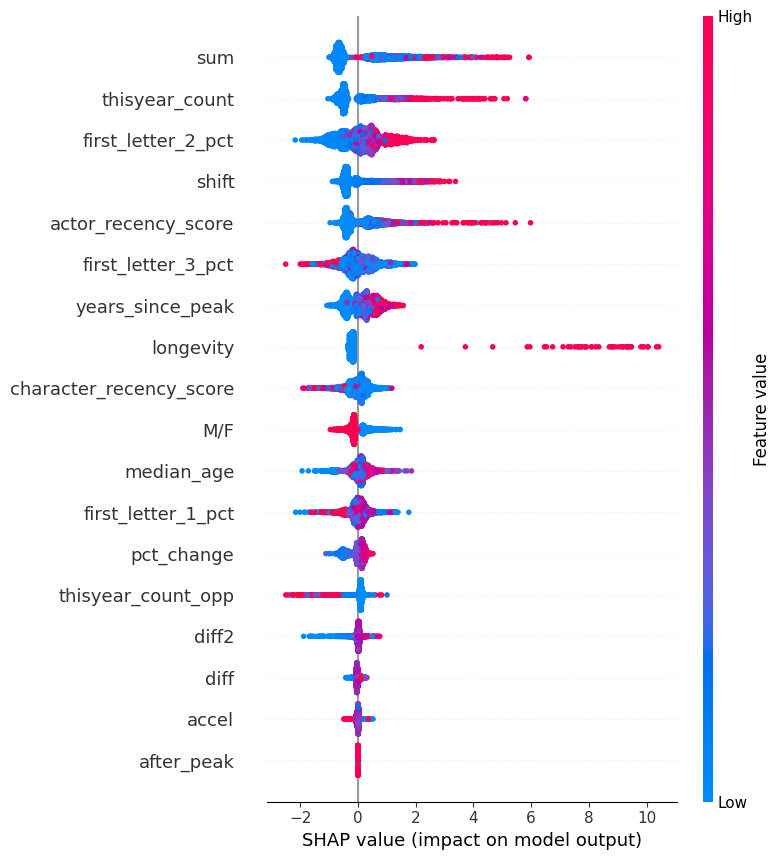

 98%|===================| 4342/4426 [00:19<00:00]        

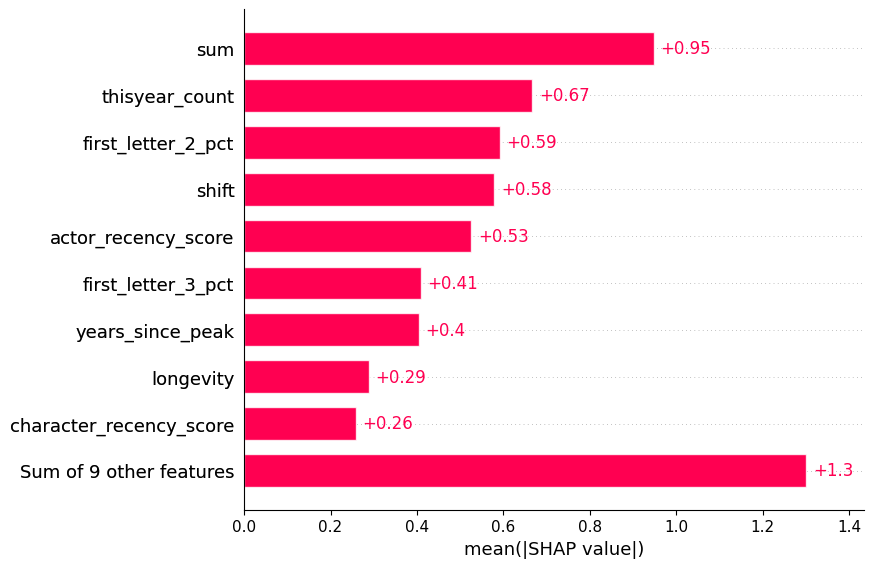

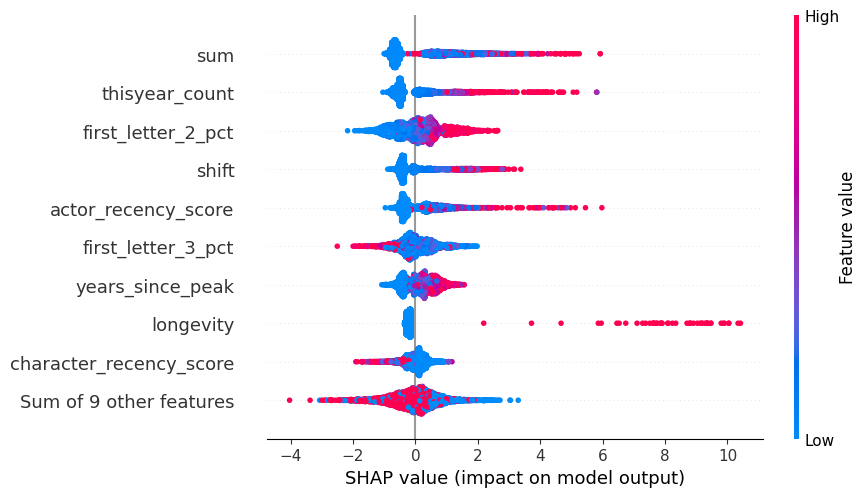

,state,name,M/F,first_year,median_year,pct,peak_pct_year,peak_pct,has_peaked,longevity,...,year,first_letter_1_pct,first_letter_1_pct_change,first_letter_2_pct,first_letter_2_pct_change,first_letter_3_pct,first_letter_3_pct_change,actor_recency_score,character_recency_score,y
0,US,Shelva,F,1937,1940,0.000059,1937,0.000176,1,0.0,...,1992,0.092766,-0.007713,0.021895,0.022871,0.008309,-0.057600,0.000000,0.000000,0.0
1,US,Shelba,F,1937,1941,0.000104,1937,0.000312,1,0.0,...,1992,0.092766,-0.007713,0.021895,0.022871,0.008309,-0.057600,0.000000,0.000000,0.0
2,US,Melvyn,M,1937,1942,0.000200,1938,0.000258,1,0.0,...,1992,0.083813,-0.049057,0.000596,-0.049408,0.000450,-0.053206,0.004541,0.000000,0.0
3,US,Betty,M,1937,1944,0.000053,1939,0.000115,1,0.0,...,1992,0.056593,0.029490,0.008544,-0.019945,0.000000,0.000000,1.535995,3.648109,0.0
4,US,Ima,F,1937,1944,0.000056,1937,0.000140,1,0.0,...,1992,0.005141,-0.077517,0.000414,0.514381,0.000356,0.650606,0.000000,0.000002,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,US,Bronte,F,1969,1992,0.000065,1992,0.000065,1,0.0,...,1992,0.055148,-0.014464,0.044932,-0.012426,0.004079,0.110663,0.000000,0.000488,0.0
4422,US,Shaquille,M,1989,1992,0.000249,1992,0.000249,1,0.0,...,1992,0.049404,-0.023630,0.007629,-0.019393,0.006749,-0.019946,0.000000,0.000000,0.0
4423,US,Keanu,M,1990,1992,0.000050,1992,0.000050,1,0.0,...,1992,0.038275,-0.029571,0.020329,-0.042847,0.000256,0.297739,1.750000,0.000000,0.0
4424,US,Lexus,F,1990,1992,0.000096,1992,0.000096,1,0.0,...,1992,0.048600,-0.047244,0.007289,-0.021386,0.000266,0.369026,0.000000,0.000000,0.0


Accuracy: 0.9807953004970628
Precision: 0.8771929824561403
Recall: 0.390625
F1: 0.5405405405405405


,state,name,M/F,first_year_true,year_true,count,pct_true,peak_pct_year_true,peak_pct_true,has_peaked_true,...,year_pred,first_letter_1_pct,first_letter_1_pct_change,first_letter_2_pct,first_letter_2_pct_change,first_letter_3_pct,first_letter_3_pct_change,actor_recency_score,character_recency_score,y_pred
0,US,Aaron,F,1937,1992,91.0,0.000045,1976,0.000098,1,...,1992,0.143005,-0.033572,0.000055,-0.087438,0.000055,-0.087438,2.101258e+00,1.210950e+00,0.0
1,US,Aaron,M,1937,1992,14509.0,0.006912,1981,0.007890,1,...,1992,0.091399,0.036444,0.007758,0.034494,0.007758,0.034494,2.101258e+00,1.210950e+00,0.0
2,US,Abbey,F,1938,1992,431.0,0.000215,1999,0.000365,0,...,1992,0.143005,-0.033572,0.003535,0.025855,0.001072,-0.046038,2.980960e-08,7.965103e-03,0.0
3,US,Abbie,F,1937,1992,260.0,0.000130,2003,0.000268,0,...,1992,0.143005,-0.033572,0.003535,0.025855,0.001072,-0.046038,6.250000e-02,9.976196e-02,0.0
4,US,Abby,F,1937,1992,1081.0,0.000539,2003,0.001021,0,...,1992,0.143005,-0.033572,0.003535,0.025855,0.001072,-0.046038,6.262208e-02,9.961414e-02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,US,Zelma,F,1937,1992,8.0,0.000004,1937,0.000173,1,...,1992,0.000862,0.337240,0.000050,0.035345,0.000019,-0.039121,0.000000e+00,0.000000e+00,0.0
4422,US,Zena,F,1937,1992,52.0,0.000026,1964,0.000113,1,...,1992,0.000862,0.337240,0.000050,0.035345,0.000031,0.085496,9.766866e-04,2.980232e-08,0.0
4423,US,Zina,F,1937,1992,21.0,0.000010,1964,0.000405,1,...,1992,0.000862,0.337240,0.000013,-0.259300,0.000013,-0.259300,1.501758e-08,6.103516e-05,0.0
4424,US,Zoe,F,1937,1992,982.0,0.000490,2012,0.003334,0,...,1992,0.000862,0.337240,0.000682,0.409261,0.000682,0.409261,2.195313e+00,5.200882e-01,0.0


,state,name,M/F,first_year_true,year_true,count,pct_true,peak_pct_year_true,peak_pct_true,has_peaked_true,...,year_pred,first_letter_1_pct,first_letter_1_pct_change,first_letter_2_pct,first_letter_2_pct_change,first_letter_3_pct,first_letter_3_pct_change,actor_recency_score,character_recency_score,y_pred
106,US,Alice,F,1937,1992,688.0,0.000343,1938,0.006561,1,...,1992,0.143005,-0.033572,0.041068,0.039140,0.007440,-0.053176,3.052360,6.554592,0.0
123,US,Allison,F,1937,1992,6902.0,0.003443,1995,0.004229,0,...,1992,0.143005,-0.033572,0.041068,0.039140,0.005472,0.051940,1.828735,1.759152,0.0
179,US,Andrea,F,1937,1992,8024.0,0.004003,1981,0.006534,1,...,1992,0.143005,-0.033572,0.024023,0.012723,0.005121,0.024687,3.347832,0.920254,0.0
185,US,Andrew,M,1937,1992,30538.0,0.014548,1987,0.018565,1,...,1992,0.091399,0.036444,0.036969,-0.011925,0.019354,-0.001281,10.240759,1.565700,1.0
199,US,Angelo,M,1937,1992,761.0,0.000363,2005,0.000608,0,...,1992,0.091399,0.036444,0.036969,-0.011925,0.002037,0.119068,0.597586,0.725552,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,US,Valerie,F,1937,1992,2349.0,0.001172,1959,0.003515,1,...,1992,0.017505,0.069548,0.006012,0.062755,0.002123,0.095933,1.515539,0.432942,0.0
4303,US,Victor,M,1937,1992,4292.0,0.002045,2003,0.002111,0,...,1992,0.005486,-0.035473,0.004928,-0.033885,0.002463,0.008164,8.716221,3.811110,1.0
4304,US,Victoria,F,1937,1992,11907.0,0.005940,1993,0.006556,0,...,1992,0.017505,0.069548,0.009189,0.089194,0.007416,0.110057,4.992788,1.056695,1.0
4319,US,Vivian,F,1937,1992,909.0,0.000453,1940,0.001914,1,...,1992,0.017505,0.069548,0.009189,0.089194,0.000827,0.112311,0.786395,1.942742,0.0


In [33]:
first_year_to_predict = 1993
years_to_predict_in_fitting = 15
years_to_fit_in_fitting = 30
name_usage_cutoff = 100
my_predictor = MyPredictor()
data_to_fit = select_top_names(trainval, first_year_to_predict=first_year_to_predict, cutoff=name_usage_cutoff)
data_to_eval = select_top_names(test, first_year_to_predict=first_year_to_predict, cutoff=name_usage_cutoff)
my_predictor.fit(historical_data=data_to_fit, first_year_to_predict=first_year_to_predict-years_to_predict_in_fitting, years_to_fit=years_to_fit_in_fitting, names_csv='longevity_names_1992.csv')
results = evaluate(predictor=my_predictor, data_held_out=data_to_eval, first_year_to_predict=first_year_to_predict, metric='all')
results

In [34]:
results[['name', 'M/F', 'y_true', 'y_pred']]

,name,M/F,y_true,y_pred
106,Alice,F,1.0,0.0
123,Allison,F,1.0,0.0
179,Andrea,F,1.0,0.0
185,Andrew,M,1.0,1.0
199,Angelo,M,1.0,0.0
...,...,...,...,...
4271,Valerie,F,1.0,0.0
4303,Victor,M,1.0,1.0
4304,Victoria,F,1.0,1.0
4319,Vivian,F,1.0,0.0


In [35]:
results[results['y_true'] == results['y_pred']][['name', 'M/F', 'y_true', 'y_pred']]

,name,M/F,y_true,y_pred
185,Andrew,M,1.0,1.0
209,Ann,F,1.0,1.0
210,Anna,F,1.0,1.0
216,Anne,F,1.0,1.0
227,Anthony,M,1.0,1.0
347,Barbara,F,1.0,1.0
666,Catherine,F,1.0,1.0
722,Charles,M,1.0,1.0
788,Christopher,M,1.0,1.0
830,Clifton,M,1.0,1.0


In [36]:
results[(results['y_true'] == 1) & (results['y_pred'] == 0)][['name', 'M/F', 'y_true', 'y_pred']]

,name,M/F,y_true,y_pred
106,Alice,F,1.0,0.0
123,Allison,F,1.0,0.0
179,Andrea,F,1.0,0.0
199,Angelo,M,1.0,0.0
313,Audrey,F,1.0,0.0
...,...,...,...,...
4100,Terrance,M,1.0,0.0
4119,Theodore,M,1.0,0.0
4250,Tyson,M,1.0,0.0
4271,Valerie,F,1.0,0.0


In [37]:
results[(results['y_true'] == 0) & (results['y_pred'] == 1)][['name', 'M/F', 'y_true', 'y_pred']]

,name,M/F,y_true,y_pred
491,Brian,M,0.0,1.0
806,Claire,F,0.0,1.0
1464,Faith,F,0.0,1.0
2838,Madeline,F,0.0,1.0
2851,Maggie,F,0.0,1.0
2948,Mark,M,0.0,1.0
3148,Monica,F,0.0,1.0
